In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm

import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [2]:
DATA_DIR = 'data'

# Directory to save logs and trained model
ROOT_DIR = ''

In [3]:
os.chdir('Mask_RCNN')


In [4]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
import keras
import tensorflow as tf


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11170310648189082592
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16474068362380223028
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15863155754984941507
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16824490394
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12040754820415432986
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [17]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 sahand sahand 246M Nov 25  2017 mask_rcnn_coco.h5


In [8]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [9]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [10]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [11]:
ls

assets/  MANIFEST.in           mask_rcnn_coco.h5.4  requirements.txt
build/   mask_rcnn_balloon.h5  mask_rcnn_coco.h5.5  samples/
data/    mask_rcnn_coco.h5     mask_rcnn_coco.h5.6  setup.cfg
dist/    mask_rcnn_coco.h5.1   mask_rcnn.egg-info/  setup.py
images/  mask_rcnn_coco.h5.2   mrcnn/               weights/
LICENSE  mask_rcnn_coco.h5.3   README.md


In [12]:
anns = pd.read_csv('data/stage_2_train_labels.csv')
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)


In [24]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [25]:
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.20539.1517874428.582292
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'afb87feb-0409-42d0-b5cf-7e6a820f67c0'
(0010, 0020) Patient ID                          LO: 'afb87feb-0409-42d0-b5cf-7e6a820f67c0'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [17]:
ORIG_SIZE = 1024


In [18]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


In [19]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [20]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    0bbb1ff7-dba6-4d5b-affe-b3ca0050d965
 x                                              65
 y                                             445
 width                                         265
 height                                        255
 Target                                          1
 Name: 963, dtype: object]

In [21]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
data/stage_2_train_images/3f2b878e-9e3b-410b-a739-b43d81b98692.dcm
[1 1]


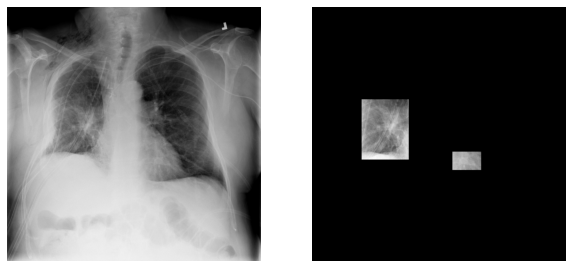

In [22]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

/home/sahand/anaconda3/envs/rcnn/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


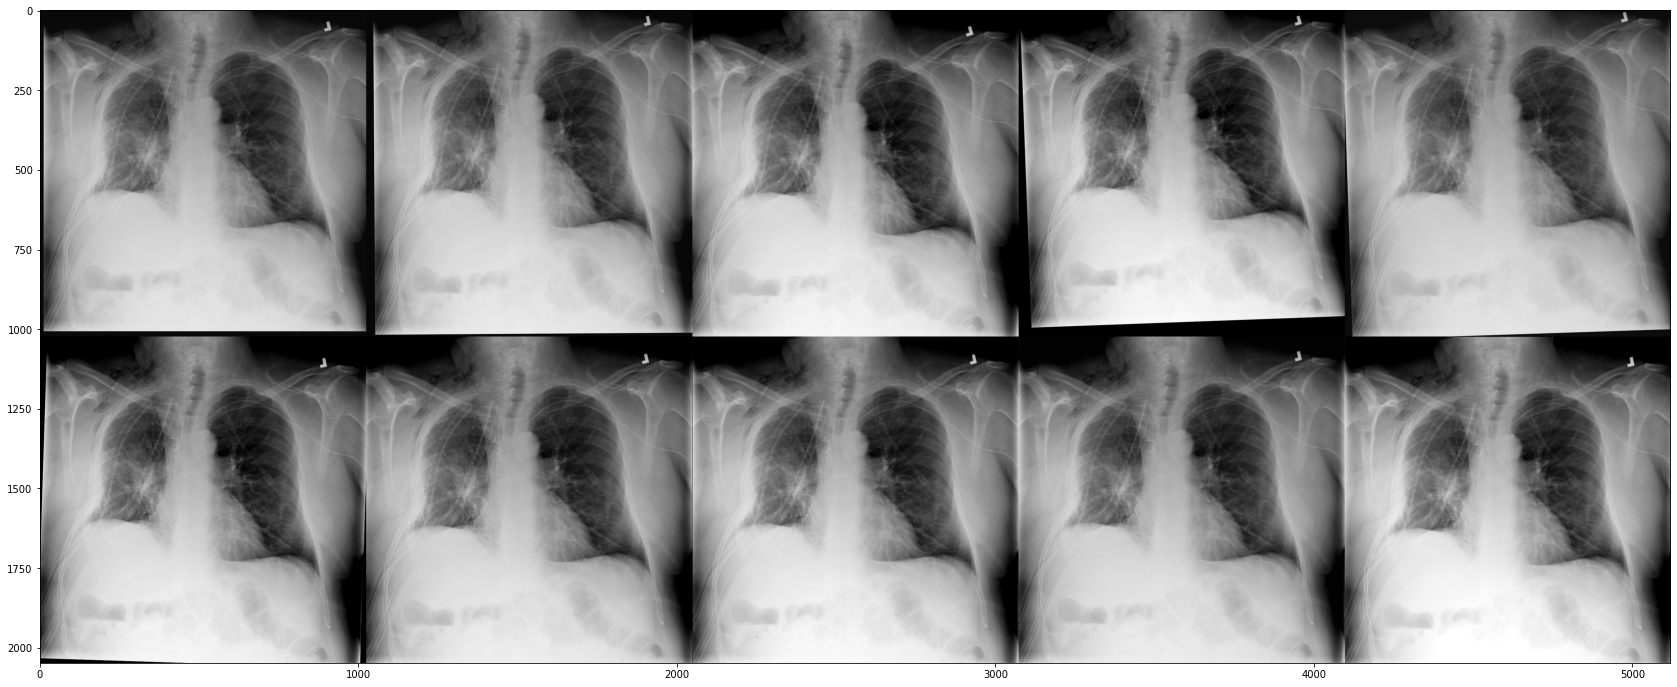

In [23]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [24]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead




In [25]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")


In [26]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: pneumonia20200527T2329/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDis

In [27]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.006

Checkpoint Path: pneumonia20200527T2329/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNo

In [28]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=0.0012000000000000001

Checkpoint Path: pneumonia20200527T2329/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [34]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/10,
            epochs=32,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 16. LR=0.0006000000000000001

Checkpoint Path: pneumonia20200527T2329/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

In [35]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.082263,0.023465,1.091964,0.115267,0.426972,0.424593,1.786656,0.024517,0.533032,0.287193,0.539098,0.402815
2,1.598689,0.019051,0.521760,0.261112,0.429209,0.367553,1.756290,0.024867,0.659999,0.234999,0.458992,0.377431
3,1.618680,0.018921,0.524469,0.285475,0.412533,0.377270,1.621183,0.018485,0.502159,0.293247,0.426102,0.381180
4,1.513625,0.015860,0.548132,0.180641,0.389424,0.379556,1.495019,0.015753,0.434099,0.259420,0.410376,0.375359
5,1.351690,0.011219,0.383084,0.188539,0.395282,0.373553,1.417116,0.014900,0.415107,0.210338,0.400810,0.375948
6,1.422173,0.012087,0.438600,0.178106,0.417695,0.375672,1.410472,0.013261,0.413253,0.226129,0.387340,0.370476
7,1.256176,0.010593,0.337849,0.174603,0.369701,0.363417,1.297787,0.011917,0.378315,0.185344,0.358272,0.363924
8,1.264402,0.011230,0.381635,0.161549,0.351908,0.358067,1.250870,0.010928,0.340668,0.180250,0.357724,0.361287
9,1.303924,0.010083,0.397066,0.172951,0.362186,0.361624,1.235980,0.010316,0.325811,0.192676,0.347787,0.359376
10,1.243761,0.009790,0.310009,0.204804,0.363108,0.356037,1.252424,0.010814,0.344430,0.188096,0.347628,0.361443


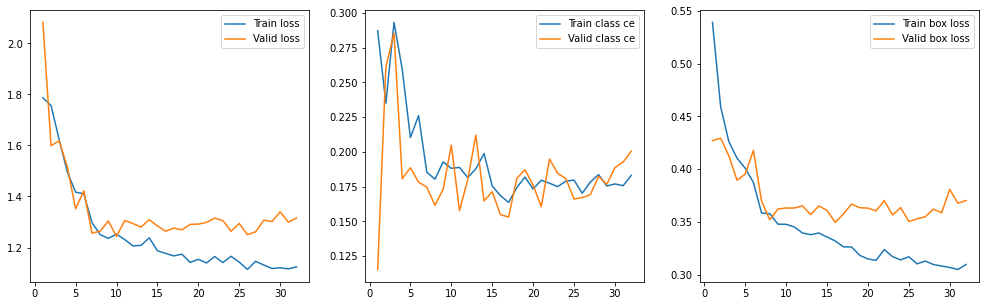

In [36]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [38]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 10 1.2437614238262176


In [43]:
ROOT_DIR

''

In [10]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
model_path = "weights/mask_rcnn_pneumonia_0010.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  weights/mask_rcnn_pneumonia_0010.h5




In [11]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 



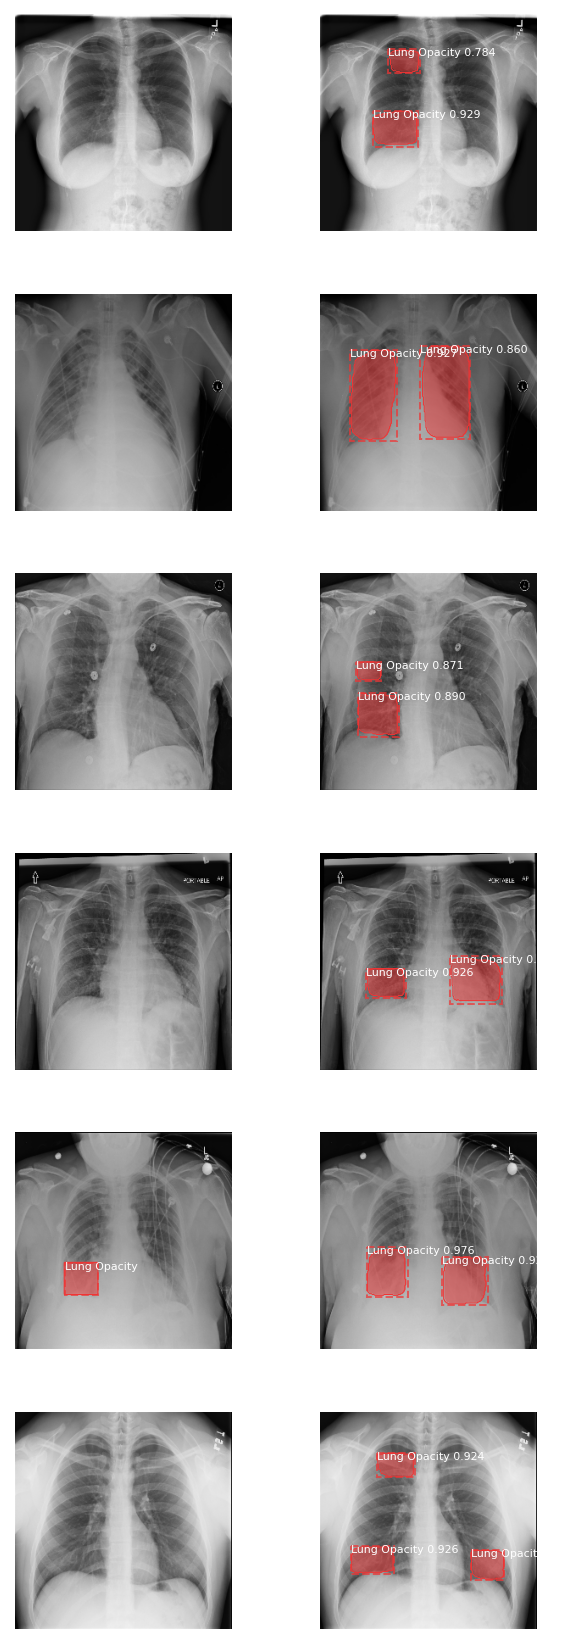

In [24]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [12]:
test_image_fps = get_dicom_fps(test_dicom_dir)


04df4d20-f843-487e-911e-8f68113172ce
[105  51 184 104]
x 204 y 420 h 212 w 316
1f0dd281-9888-461e-9b45-cdb01eac4a49
[125  65 162 113]
x 260 y 500 h 192 w 148
[124 155 173 192]
x 620 y 496 h 148 w 196
012e4288-deac-438d-af9e-a3cb7478ed7f
[116  66 177 106]
x 264 y 464 h 160 w 244
008102ab-5ea6-414d-bff1-9f55d148a80d
[142  79 176 112]
x 316 y 568 h 132 w 136
[142 149 185 212]
x 596 y 568 h 252 w 172


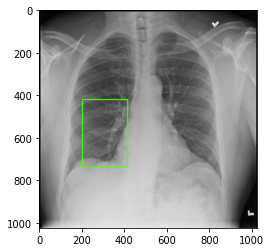

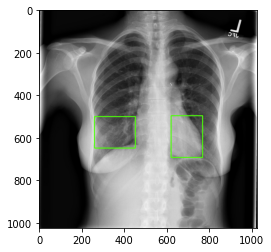

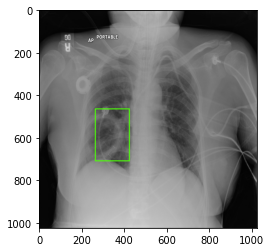

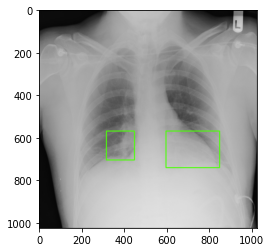

In [13]:
ORIG_SIZE = 1024

def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()